# Predicting IMDB Rating of the IMDB Top 250

Using a tree-based model, the goal of this project was to predict a rating of the IMDB top 250. The new skills being practiced in this project included:

- Web scraping
- Syncing with an API
- Tree based model

### Load in the data

In [33]:
#load in packages

import numpy as np
from imdbpie import Imdb
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, roc_auc_score, recall_score

In [1]:
#implement the imdb pie sync

imdb = Imdb()
imdb = Imdb(anonymize=True)
imdb = Imdb(cache=True)

In [2]:
raw = imdb.top_250()

In [3]:
raw

[{u'can_rate': True,
  u'image': {u'height': 1388,
   u'url': u'http://ia.media-imdb.com/images/M/MV5BODU4MjU4NjIwNl5BMl5BanBnXkFtZTgwMDU2MjEyMDE@._V1_.jpg',
   u'width': 933},
  u'num_votes': 1679506,
  u'rating': 9.3,
  u'tconst': u'tt0111161',
  u'title': u'The Shawshank Redemption',
  u'type': u'feature',
  u'year': u'1994'},
 {u'can_rate': True,
  u'image': {u'height': 500,
   u'url': u'http://ia.media-imdb.com/images/M/MV5BMjEyMjcyNDI4MF5BMl5BanBnXkFtZTcwMDA5Mzg3OA@@._V1_.jpg',
   u'width': 333},
  u'num_votes': 1149127,
  u'rating': 9.2,
  u'tconst': u'tt0068646',
  u'title': u'The Godfather',
  u'type': u'feature',
  u'year': u'1972'},
 {u'can_rate': True,
  u'image': {u'height': 500,
   u'url': u'http://ia.media-imdb.com/images/M/MV5BNDc2NTM3MzU1Nl5BMl5BanBnXkFtZTcwMTA5Mzg3OA@@._V1_.jpg',
   u'width': 333},
  u'num_votes': 785866,
  u'rating': 9,
  u'tconst': u'tt0071562',
  u'title': u'The Godfather: Part II',
  u'type': u'feature',
  u'year': u'1974'},
 {u'can_rate': True,
 

convert this to a dataframe so we can start cleaning it up

In [4]:
raw_df = pd.DataFrame.from_dict(raw)

In [5]:
raw_df.head()

,can_rate,image,num_votes,rating,tconst,title,type,year
0,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,1679506,9.3,tt0111161,The Shawshank Redemption,feature,1994
1,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,1149127,9.2,tt0068646,The Godfather,feature,1972
2,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,785866,9.0,tt0071562,The Godfather: Part II,feature,1974
3,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,1664606,9.0,tt0468569,The Dark Knight,feature,2008
4,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,859607,8.9,tt0108052,Schindler's List,feature,1993


begin to clean up this data frame

In [6]:
raw_df.dtypes

can_rate        bool
image         object
num_votes      int64
rating       float64
tconst        object
title         object
type          object
year          object
dtype: object

In [8]:
#the ratings only go between 8 and 9.3

raw_df.describe()

,num_votes,rating
count,2.500000e+02,250.000000
mean,4.032483e+05,8.315200
std,3.309846e+05,0.231133
min,2.506900e+04,8.000000
25%,1.228708e+05,8.100000
50%,3.235245e+05,8.300000
75%,5.946522e+05,8.400000
max,1.679506e+06,9.300000


In [9]:
#no null values

raw_df.isnull().sum()

can_rate     0
image        0
num_votes    0
rating       0
tconst       0
title        0
type         0
year         0
dtype: int64

In [10]:
#what is the can_rate column?

raw_df['can_rate'].unique()

array([True], dtype=object)

In [11]:
#do not need this, or the images column so well delete

del raw_df['can_rate']
del raw_df['image']

In [12]:
#drop type since all these are the same

raw_df["type"].unique()

array([u'feature'], dtype=object)

In [13]:
del raw_df['type']

In [14]:
#convert the years into an integer

raw_df['year'] = raw_df['year'].apply(lambda x: int(x))

In [15]:
#check to see what this looks like

raw_df.head()

,num_votes,rating,tconst,title,year
0,1679506,9.3,tt0111161,The Shawshank Redemption,1994
1,1149127,9.2,tt0068646,The Godfather,1972
2,785866,9.0,tt0071562,The Godfather: Part II,1974
3,1664606,9.0,tt0468569,The Dark Knight,2008
4,859607,8.9,tt0108052,Schindler's List,1993


need to pull more info since there aren't enough features to include. consider:
- title.certification (from API)
- genre (how to deal with multiple genres?)
- director
- runtime
- plot keywords
- month of release
- actor/actress

In [16]:
#pull title.certification

certification = []
for item in raw_df["tconst"]:
    title = imdb.get_title_by_id(item)
    final = title.certification
    certification.append(final)
    
print certification

[u'R', u'R', u'R', u'PG-13', u'R', u'Not Rated', u'R', u'PG-13', u'Not Rated', u'TV-MA', u'PG-13', u'PG', u'PG-13', u'PG-13', u'PG-13', u'R', u'R', u'R', u'Unrated', u'PG', u'R', u'R', u'R', u'Approved', u'R', u'PG-13', u'Unrated', u'M', u'PG', u'TV-MA', u'TV-14', u'PG-13', u'TV-PG', u'Approved', u'Passed', u'PG', u'R', u'G', u'R', u'Approved', u'TV-14', u'R', u'R', u'PG', u'R', u'R', u'R', u'R', u'PG-13', u'G', u'Approved', u'Not Rated', u'TV-14', u'Approved', u'R', u'PG', u'Approved', u'R', u'R', u'Unrated', u'G', u'PG-13', u'R', u'R', u'TV-14', u'R', u'Approved', u'R', u'Approved', u'R', u'Approved', u'Approved', u'PG', u'Not Rated', u'TV-MA', u'R', u'R', u'Unrated', u'X', u'R', u'Passed', u'G', u'PG', u'Not Rated', u'R', u'PG', u'R', u'PG', u'G', u'Not Rated', u'G', u'TV-G', u'R', u'PG', u'R', u'Not Rated', u'TV-MA', u'Approved', u'Unrated', u'Approved', u'TV-14', u'E', u'PG-13', u'Not Rated', u'TV-PG', u'PG-13', u'Unrated', u'R', u'PG-13', u'TV-PG', u'R', u'Not Rated', u'PG', u'R'

In [17]:
#add these onto the dataframe

raw_df["cert"] = certification

In [21]:
#initialize webscraping to get all the other listed things

import requests
import bs4
from bs4 import BeautifulSoup

imdb_url = "http://www.imdb.com/title/"
urllist = []
for item in raw_df["tconst"]:
    newurl = imdb_url + item
    urllist.append(newurl)

print urllist[249]

http://www.imdb.com/title/tt0118694


In [210]:
#try only one result

r = requests.get('http://www.imdb.com/title/tt0118694')
test_soups = BeautifulSoup(r.content, "lxml")
duration = test_soups.findAll("time", itemprop = "duration")
genre = test_soups.findAll("span", itemprop="genre")
director = test_soups.find("span", itemprop="director").text
keywords = test_soups.findAll("span", itemprop = "keywords")
month = test_soups.find("meta", itemprop = "datePublished").text
actors_3 = test_soups.findAll("span", itemprop="actors")
print duration
print genre
print director
print keywords
print month
print actors_3

[<time datetime="PT98M" itemprop="duration">\n                        1h 38min\n                    </time>, <time datetime="PT98M" itemprop="duration">98 min</time>]
[<span class="itemprop" itemprop="genre">Drama</span>, <span class="itemprop" itemprop="genre">Romance</span>]

Kar-Wai Wong (as Kar Wai Wong)            
[<span class="itemprop" itemprop="keywords">infidelity</span>, <span class="itemprop" itemprop="keywords">unfaithfulness</span>, <span class="itemprop" itemprop="keywords">adultery</span>, <span class="itemprop" itemprop="keywords">loneliness</span>, <span class="itemprop" itemprop="keywords">newspaper</span>]

[<span itemprop="actors" itemscope="" itemtype="http://schema.org/Person">\n<a href="/name/nm0504897?ref_=tt_ov_st_sm" itemprop="url"><span class="itemprop" itemprop="name">Tony Chiu Wai Leung</span></a>,             </span>, <span itemprop="actors" itemscope="" itemtype="http://schema.org/Person">\n<a href="/name/nm0001041?ref_=tt_ov_st_sm" itemprop="url"><span 

In [97]:
#try for everything

results = []

for url in urllist:
    r = requests.get(url)
    thesoups = BeautifulSoup(r.content, "lxml")
    duration = thesoups.findAll("time", itemprop = "duration")
    genre = thesoups.findAll("span", itemprop="genre")
    director = thesoups.findAll("span", itemprop="director")
    keywords = thesoups.findAll("span", itemprop = "keywords")
    month = thesoups.findAll("meta", itemprop = "datePublished")
    actors_3 = thesoups.findAll("span", itemprop="actors")
    item = duration + genre + director + keywords + month + actors_3
    results.append(item)

In [98]:
#take a look at one result

len(results[249])

15

In [103]:
results[249]

[<time datetime="PT98M" itemprop="duration">\n                        1h 38min\n                    </time>,
 <time datetime="PT98M" itemprop="duration">98 min</time>,
 <span class="itemprop" itemprop="genre">Drama</span>,
 <span class="itemprop" itemprop="genre">Romance</span>,
 <span itemprop="director" itemscope="" itemtype="http://schema.org/Person">\n<a href="/name/nm0939182?ref_=tt_ov_dr" itemprop="url"><span class="itemprop" itemprop="name">Kar-Wai Wong</span></a> (as Kar Wai Wong)            </span>,
 <span class="itemprop" itemprop="keywords">infidelity</span>,
 <span class="itemprop" itemprop="keywords">unfaithfulness</span>,
 <span class="itemprop" itemprop="keywords">adultery</span>,
 <span class="itemprop" itemprop="keywords">loneliness</span>,
 <span class="itemprop" itemprop="keywords">newspaper</span>,
 <meta content="2001-03-09" itemprop="datePublished"/>,
 <meta content="2002-03-06" itemprop="datePublished"/>,
 <span itemprop="actors" itemscope="" itemtype="http://sch

In [101]:
#time seems to be the easiest to pull out - try that first

results[249][1].find("time", item="duration")
time = results[249][1].text.encode("ascii")
print time

98 min


In [183]:
#write a function to pull out time into a list

def duration(biglist):
    durationlist = []
    for i in biglist:
        length = i[1].text.encode("ascii")
        durationlist.append(length)
    return durationlist

In [108]:
#implement the function

timelist = duration(results)

In [109]:
#add it into the dataframe

raw_df["duration"] = timelist

In [115]:
#clean up the dataframe a bit by changing the encoding

raw_df["title"] = raw_df["title"].apply(lambda x: x.encode('utf8'))
raw_df["cert"] = raw_df["cert"].apply(lambda x: x.encode('utf8'))
raw_df["duration"] = raw_df["duration"].apply(lambda x: x.encode('utf8'))

In [116]:
#take a second to convert to save

raw_df.to_csv("imdb.csv")

In [120]:
#write a function to convert the time which is currently in a string

def converttime(boops):
    if " min" in boops:
        string = boops.replace(" min", "")
        string = int(string)
        return string
    else:
        boops

converttime("142 min")

142

In [121]:
#apply to dataframe

raw_df["duration"] = raw_df["duration"].apply(converttime)

In [122]:
#check to see if it worked

raw_df["duration"].unique()

array([ 142.,  175.,  202.,  152.,  195.,   96.,  154.,  201.,  161.,
        139.,  178.,  124.,  148.,  179.,  133.,  146.,  136.,  207.,
        121.,  130.,  127.,  118.,  106.,  116.,  110.,  165.,  125.,
        169.,  119.,  102.,  109.,   87.,  115.,  112.,  189.,  137.,
        151.,  150.,  107.,  155.,  113.,  153.,   89.,   95.,  117.,
         88.,  144.,   98.,  164.,  122.,  134.,  120.,  229.,  149.,
        128.,  131.,   99.,  103.,  216.,  129.,  108.,  160.,   81.,
        104.,   91.,   68.,  138.,  132.,  170.,  123.,  140.,  126.,
        156.,  172.,   86.,  143.,  162.,   94.,   67.,  180.,  186.,
        135.,  177.,  183.,  105.,  238.,  147.,  100.,   92.,  111.,
        158.,   85.,  212.,   93.,  163.,  191.,  101.,  184.,  141.,
        114.,   nan,  188.,  320.,   84.])

In [119]:
#there's one duration that put in drama rather than a time - figure out what that one is

raw_df[raw_df["duration"]=='Drama'].index

Int64Index([237], dtype='int64')

In [123]:
#manually checked to see what that missing value was - it was 146 minutes

raw_df.replace(to_replace=np.nan, value = 146)

,num_votes,rating,tconst,title,year,cert,duration
0,1679506,9.3,tt0111161,The Shawshank Redemption,1994,R,142.0
1,1149127,9.2,tt0068646,The Godfather,1972,R,175.0
2,785866,9.0,tt0071562,The Godfather: Part II,1974,R,202.0
3,1664606,9.0,tt0468569,The Dark Knight,2008,PG-13,152.0
4,859607,8.9,tt0108052,Schindler's List,1993,R,195.0
5,444373,8.9,tt0050083,12 Angry Men,1957,Not Rated,96.0
6,1316480,8.9,tt0110912,Pulp Fiction,1994,R,154.0
7,1208500,8.9,tt0167260,The Lord of the Rings: The Return of the King,2003,PG-13,201.0
8,500457,8.9,tt0060196,"The Good, the Bad and the Ugly",1966,Not Rated,161.0
9,1338558,8.8,tt0137523,Fight Club,1999,TV-MA,139.0


In [259]:
#pull the 3 actors, writing a function

def actors(biglist):
    actorlist = []
    for i in biglist:
        movielist = []
        actor1 = i[-3].text
        movielist.append(actor1)
        actor2 = i[-2].text
        movielist.append(actor2)
        actor3 = i[-1].text
        movielist.append(actor3)
        actorlist.append(movielist)
    return actorlist

In [315]:
#implement the function

actor_list = actors(results)

In [771]:
#append onto dataframe

raw_df["stars"] = actor_list

In [318]:
#check to see what happened - right now its 3 actors/actresses in a list which will need to be fixed later

raw_df.head()

,num_votes,rating,tconst,title,year,cert,duration,stars
0,1679506,9.3,tt0111161,The Shawshank Redemption,1994,R,142.0,"[\nTim Robbins, , \nMorgan Freeman..."
1,1149127,9.2,tt0068646,The Godfather,1972,R,175.0,"[\nMarlon Brando, , \nAl Pacino, ..."
2,785866,9.0,tt0071562,The Godfather: Part II,1974,R,202.0,"[\nAl Pacino, , \nRobert De Niro, ..."
3,1664606,9.0,tt0468569,The Dark Knight,2008,PG-13,152.0,"[\nChristian Bale, , \nHeath Ledge..."
4,859607,8.9,tt0108052,Schindler's List,1993,R,195.0,"[\nLiam Neeson, , \nRalph Fiennes,..."


In [ ]:
#STILL LEFT TO DO
#genre (how to deal with multiple genres?)
#director
#plot keywords
#month of release

In [381]:
#Pull all genres for functions 

def genre(result):
    genre_list = []
    for movie in result:
        moviegenrelist = []
        for line in movie:
            if "genre" in str(line):
                string = str(line)
                final = string[40:-7]
                moviegenrelist.append(final)
        genre_list.append(moviegenrelist)
    return genre_list

genre(results[3:5])

[['Action', 'Adventure', 'Crime'], ['Biography', 'Drama', 'History']]

In [382]:
#apply the function

genre_list = genre(results)

In [752]:
#implement the function

raw_df["genre"] = genre_list

In [384]:
#check to see how it went - same issue as actors

raw_df.head()   

,num_votes,rating,tconst,title,year,cert,duration,stars,genre
0,1679506,9.3,tt0111161,The Shawshank Redemption,1994,R,142.0,"[\nTim Robbins, , \nMorgan Freeman...","[Crime, Drama]"
1,1149127,9.2,tt0068646,The Godfather,1972,R,175.0,"[\nMarlon Brando, , \nAl Pacino, ...","[Crime, Drama]"
2,785866,9.0,tt0071562,The Godfather: Part II,1974,R,202.0,"[\nAl Pacino, , \nRobert De Niro, ...","[Crime, Drama]"
3,1664606,9.0,tt0468569,The Dark Knight,2008,PG-13,152.0,"[\nChristian Bale, , \nHeath Ledge...","[Action, Adventure, Crime]"
4,859607,8.9,tt0108052,Schindler's List,1993,R,195.0,"[\nLiam Neeson, , \nRalph Fiennes,...","[Biography, Drama, History]"


In [385]:
#STILL LEFT TO DO
#director
#plot keywords
#month of release

raw_df.to_csv("imdb.csv")

In [403]:
#write a function to pull month of release

def datetime(result):
    datetime_list = []
    for movie in result:
        movietimelist = []
        for line in movie:
            if "meta" in str(line):
                string = str(line)
                final = string[15:-28]
                movietimelist.append(final)
        datetime_list.append(movietimelist)
    return datetime_list

datetime_list = datetime(results)

In [404]:
#returns 2 - can't figure out waht the second item is
datetime_list

[['1994-10-14', '2003-11-26'],
 ['1972-03-24', '2005-09-30'],
 ['1974-12-20', '2001-05-09'],
 ['2008-07-18', '2008-07-09'],
 ['1994-02-04', '2010-08-07'],
 ['1957-04', '2002-09-18'],
 ['1994-10-14', '2005-11-17'],
 ['2003-12-17', '2003-12-17'],
 ['1967-12-29', '2001-04-16'],
 ['1999-10-15', '2001-03-20'],
 ['2001-12-19', '2002-01-30'],
 ['1980-06-20', '2000-05-02'],
 ['1994-07-06', '2002-04-08'],
 ['2010-07-16', '2010-07-10'],
 ['2002-12-18', '2010-08-12'],
 ['1975-11-21', '2005-01-14'],
 ['1990-09-21', '2003-03-31'],
 ['1999-03-31', '2000-09-19'],
 ['1956-11-19', '1998-12-26'],
 ['1977-05-25', '2003-10-26'],
 ['2004-02-13', '2004-12-18'],
 ['1995-09-22', '2002-03-25'],
 ['1991-02-14', '1999-02-19'],
 ['1947-01-07', '2007-01-27'],
 ['1995-09-15', '2004-09-08'],
 ['1999-02-12', '1999-12-06'],
 ['1994-11-18', '1999-05-16'],
 ['1969-07-04', '2002-06-23'],
 ['2003-03-28', '2004-07-20'],
 ['1998-07-24', '2001-06-10'],
 ['1998-11-20', '2000-04-02'],
 ['2014-11-07', '2014-11-05'],
 ['1943-01-

In [406]:
raw_df["month"] = datetime_list

In [407]:
raw_df.head()

,num_votes,rating,tconst,title,year,cert,duration,stars,genre,month
0,1679506,9.3,tt0111161,The Shawshank Redemption,1994,R,142.0,"[\nTim Robbins, , \nMorgan Freeman...","[Crime, Drama]","[1994-10-14, 2003-11-26]"
1,1149127,9.2,tt0068646,The Godfather,1972,R,175.0,"[\nMarlon Brando, , \nAl Pacino, ...","[Crime, Drama]","[1972-03-24, 2005-09-30]"
2,785866,9.0,tt0071562,The Godfather: Part II,1974,R,202.0,"[\nAl Pacino, , \nRobert De Niro, ...","[Crime, Drama]","[1974-12-20, 2001-05-09]"
3,1664606,9.0,tt0468569,The Dark Knight,2008,PG-13,152.0,"[\nChristian Bale, , \nHeath Ledge...","[Action, Adventure, Crime]","[2008-07-18, 2008-07-09]"
4,859607,8.9,tt0108052,Schindler's List,1993,R,195.0,"[\nLiam Neeson, , \nRalph Fiennes,...","[Biography, Drama, History]","[1994-02-04, 2010-08-07]"


In [408]:
#STILL LEFT TO DO
#director
#plot keywords

raw_df.to_csv("imdb.csv")

In [411]:
#pull plot keywords

def plot_keywords(result):
    plot_list = []
    for movie in result:
        movieplotlist = []
        for line in movie:
            if "keywords" in str(line):
                string = str(line)
                final = string[43:-7]
                movieplotlist.append(final)
        plot_list.append(movieplotlist)
    return plot_list

plot_keywords(results[0:3])

[['prison',
  'escape from prison',
  'wrongful imprisonment',
  'prison cell search',
  'first person narration'],
 ['mafia', 'crime family', 'patriarch', 'rise to power', 'organized crime'],
 ['corrupt politician', 'revenge', '1950s', 'lake tahoe nevada', 'melancholy']]

In [412]:
#implement

keywords_list = plot_keywords(results)

In [413]:
#attach to data frame

raw_df["keywords"] = keywords_list

In [414]:
raw_df.head()

,num_votes,rating,tconst,title,year,cert,duration,stars,genre,month,keywords
0,1679506,9.3,tt0111161,The Shawshank Redemption,1994,R,142.0,"[\nTim Robbins, , \nMorgan Freeman...","[Crime, Drama]","[1994-10-14, 2003-11-26]","[prison, escape from prison, wrongful imprison..."
1,1149127,9.2,tt0068646,The Godfather,1972,R,175.0,"[\nMarlon Brando, , \nAl Pacino, ...","[Crime, Drama]","[1972-03-24, 2005-09-30]","[mafia, crime family, patriarch, rise to power..."
2,785866,9.0,tt0071562,The Godfather: Part II,1974,R,202.0,"[\nAl Pacino, , \nRobert De Niro, ...","[Crime, Drama]","[1974-12-20, 2001-05-09]","[corrupt politician, revenge, 1950s, lake taho..."
3,1664606,9.0,tt0468569,The Dark Knight,2008,PG-13,152.0,"[\nChristian Bale, , \nHeath Ledge...","[Action, Adventure, Crime]","[2008-07-18, 2008-07-09]","[dc comics, star died before release, based on..."
4,859607,8.9,tt0108052,Schindler's List,1993,R,195.0,"[\nLiam Neeson, , \nRalph Fiennes,...","[Biography, Drama, History]","[1994-02-04, 2010-08-07]","[jew, nazi, german soldier, jewish, german]"


In [415]:
#STILL LEFT TO DO
#director

raw_df.to_csv("imdb.csv")

In [443]:
#write function to define directors

def directorpull(result):
    director_list = []
    for movie in result:
        moviedirectorlist = []
        for line in movie:
            if "director" in str(line):
                string = str(line)
                final = string[170:-19]
                moviedirectorlist.append(final)
        director_list.append(moviedirectorlist)
    return director_list

directorpull(results[166:168])

[['Ethan Coen</span></a>, ', 'Joel Coen'], ['Sean Penn']]

In [420]:
#apply to full list

director_list = directorpull(results)

In [893]:
#amend to dataframe

raw_df["director"] = director_list

In [894]:
raw_df.head()

,num_votes,rating,title,year,cert,duration,stars,genre,month,keywords,director
0,1679506,9.3,The Shawshank Redemption,1994,R,142.0,"u\nTim Robbins, u\nMorgan Freeman, u\nBob Gunton","Crime, Drama",10,"prison, escape from prison, wrongful imprisonm...",[Frank Darabont]
1,1149127,9.2,The Godfather,1972,R,175.0,"u\nMarlon Brando, u\nAl Pacino, u\nJames Caan","Crime, Drama",3,"mafia, crime family, patriarch, rise to power,...",[Francis Ford Coppola]
2,785866,9.0,The Godfather: Part II,1974,R,202.0,"u\nAl Pacino, u\nRobert De Niro, u\nRobert Duv...","Crime, Drama",12,"corrupt politician, revenge, 1950s, lake tahoe...",[Francis Ford Coppola]
3,1664606,9.0,The Dark Knight,2008,PG-13,152.0,"u\nChristian Bale, u\nHeath Ledger, u\nAaron E...","Action, Adventure, Crime",7,"dc comics, star died before release, based on ...",[Christopher Nolan]
4,859607,8.9,Schindler's List,1993,R,195.0,"u\nLiam Neeson, u\nRalph Fiennes, u\nBen Kings...","Biography, Drama, History",2,"jew, nazi, german soldier, jewish, german",[Steven Spielberg]


In [895]:
#save final dataframe

raw_df.to_csv("imdb.csv")

### Clean the rest of the dataset

In [449]:
#start with cleaning up the director

raw_df["director"]

0                                       [Frank Darabont]
1                                 [Francis Ford Coppola]
2                                 [Francis Ford Coppola]
3                                    [Christopher Nolan]
4                                     [Steven Spielberg]
5                                         [Sidney Lumet]
6                                    [Quentin Tarantino]
7                                        [Peter Jackson]
8                                         [Sergio Leone]
9                                        [David Fincher]
10                                       [Peter Jackson]
11                                      [Irvin Kershner]
12                                     [Robert Zemeckis]
13                                   [Christopher Nolan]
14                                       [Peter Jackson]
15                                        [Milos Forman]
16                                     [Martin Scorsese]
17     [Lana Wachowski</span></

In [896]:
#for the ones that only have one director (the bulk of them), convert to string

raw_df["director"] = raw_df["director"].apply(lambda x: str(x[0]) if len(x) == 1 else x)

In [436]:
#take a look at some of the list of directors we are working with

directorlists.sort()
directorlists

array(['Adam Elliot', 'Akira Kurosawa',
       'Alejandro G. I\xc3\xb1\xc3\xa1rritu',
       'Alejandro G. I\xc3\xb1\xc3\xa1rritu</span></a> (as Alejandro Gonz\xc3\xa1lez I\xc3\xb1\xc3\xa1rritu)',
       'Alfred Hitchcock',
       'Andrei Tarkovsky</span></a> (as Andrey Tarkovskiy)',
       'Andrew Stanton', 'Andrew Stanton</span></a>, ',
       'Anthony Russo</span></a>, ', 'Anurag Kashyap', 'Asghar Farhadi',
       'Billy Wilder', 'Brian De Palma', 'Bryan Singer',
       'Byron Howard</span></a>, ', 'Carol Reed', 'Chan-wook Park',
       'Charles Chaplin',
       'Charles Chaplin</span></a> (as Charlie Chaplin)',
       'Christopher Nolan', 'Clint Eastwood',
       'Clyde Bruckman</span></a>, ', 'Curtis Hanson', 'Damien Chazelle',
       'Dami\xc3\xa1n Szifr\xc3\xb3n</span></a> (as Dami\xc3\xa1n Szifron)',
       'Danny Boyle', 'Darren Aronofsky', 'David Fincher', 'David Lean',
       'David Lynch', 'David Yates', 'Dean DeBlois</span></a>, ',
       'Denis Villeneuve', 'Elem Klimov</

In [626]:
#removing all accents

def fixupdirector(item):
    if len(item) == 1:
        if "Alejandro" in item:
            return "Alejandro Gonzalez Inarritu"
        elif "</span></a> (as Andrey Tarkovskiy)" in item:
            return item.replace("</span></a> (as Andrey Tarkovskiy)", "")
        elif "</span></a> (as Charlie Chaplin)" in item:
            return item.replace("</span></a> (as Charlie Chaplin)", "")
        elif "Szifron" in item:
            return "Damian Szifron"
        elif "</span></a> (as E. Klimov)" in item:
            return item.replace("</span></a> (as E. Klimov)", "")
        elif "</span></a> (as Francis Coppola)" in item:
            return item.replace("</span></a> (as Francis Coppola)", "")
        elif "Truffaut" in item:
            return "Francois Truffaut"
        elif "</span></a> (as H.G. Clouzot)" in item:
            return item.replace("</span></a> (as H.G. Clouzot)", "")
        elif "</span></a> (as Joon Ho Bong)" in item:
            return item.replace("</span></a> (as Joon Ho Bong)", "")
        elif "Campanella" in item:
            return "Juan Jose Campanella"
        elif "</span></a> (as Kar Wai Wong)" in item:
            return item.replace("</span></a> (as Kar Wai Wong)", "")
        elif "Lasse" in item:
            return "Lasse Hallstrom"
        elif "</span></a> (as Andrew Lau), " in item:
            return item.replace("</span></a> (as Andrew Lau), ", "")
        elif "Ozu" in item:
            return "Yasujiro Ozu"
        elif "</span></a>, " in item:
            return item.replace("</span></a>, ", "")
    else:
        return item



In [898]:
#apply this

raw_df['director'] = raw_df['director'].apply(fixupdirector)

In [548]:
#create a list of the directors with multiple directors

directorlist = raw_df["director"].order()

/Users/katty/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: order is deprecated, use sort_values(...)
  if __name__ == '__main__':


In [556]:
#pull the index of those with mulitple directors

index_multiple_directors = list(directorlist[0:26].index)

In [557]:
index_multiple_directors

[162,
 159,
 178,
 37,
 139,
 161,
 166,
 214,
 20,
 222,
 248,
 156,
 151,
 17,
 36,
 112,
 216,
 118,
 74,
 94,
 49,
 90,
 93,
 158,
 215,
 224]

In [675]:
#checking to identify the max length of directors per movie

for index in index_multiple_directors:
    print raw_df["director"][index]

['Andrew Stanton</span></a>, ', 'Lee Unkrich']
['Anthony Russo</span></a>, ', 'Joe Russo']
['Byron Howard</span></a>, ', 'Rich Moore']
Charles Chaplin</span></a> (as Charlie Chaplin)
['Clyde Bruckman</span></a>, ', 'Buster Keaton']
['Dean DeBlois</span></a>, ', 'Chris Sanders']
['Ethan Coen</span></a>, ', 'Joel Coen']
Federico Fellini
['Fernando Meirelles</span></a>, ', 'K\xc3\xa1tia Lund']
['Frank Miller</span></a>, ', 'Robert Rodriguez']
['Gary Trousdale</span></a>, ', 'Kirk Wise']
['Joel Coen</span></a>, ', 'Ethan Coen</span></a> (uncredited)']
['Joel Coen</span></a>, ', 'Ethan Coen</span></a> (uncredited)']
['Lana Wachowski</span></a> (as The Wachowski Brothers), ', 'Lilly Wachowski</span></a> (as The Wachowski Brothers)']
['Olivier Nakache</span></a>, ', 'Eric Toledano']
['Pete Docter</span></a>, ', 'Bob Peterson']
['Pete Docter</span></a>, ', 'David Silverman']
['Pete Docter</span></a>, ', 'Ronnie Del Carmen']
Quentin Tarantino
['Quentin Tarantino</span></a>, ', 'Eli Roth</span><

In [900]:
#convert these into a string and remove all the features manually so that its actual names

raw_df["director"] = raw_df["director"].apply(lambda x: str(x))

In [679]:
#create a function to change the string list into actual list of directors. will use stop words to split these up later

def cleanupdirectorsmore(i):
    if "[" in i:
        return i.replace("[", "")
    elif "]" in i:
        return i.replace("]", "") 
    elif "</span></a>, " in i:
        return i.replace("</span></a>, ", "")
    elif "</span></a> (uncredited)" in i:
        return i.replace("</span></a> (uncredited)", "")
    elif "</span></a> (as Charlie Chaplin)" in i:
        return i.replace("</span></a> (as Charlie Chaplin)", "")
    elif "</span></a> (as The Wachowski Brothers), " in i:
        return i.replace("</span></a> (as The Wachowski Brothers), ", "")
    elif "</span></a> (as Francis Coppola)" in i:
        return i.replace("</span></a> (as Francis Coppola)", "")
    else: 
        return i


In [901]:
#apply once 

raw_df["director"] = raw_df["director"].apply(cleanupdirectorsmore)
directorlist = raw_df["director"].order()
for index in index_multiple_directors:
    print raw_df["director"][index]

'Andrew Stanton</span></a>, ', 'Lee Unkrich']
'Anthony Russo</span></a>, ', 'Joe Russo']
'Byron Howard</span></a>, ', 'Rich Moore']
Charles Chaplin
'Clyde Bruckman</span></a>, ', 'Buster Keaton']
'Dean DeBlois</span></a>, ', 'Chris Sanders']
'Ethan Coen</span></a>, ', 'Joel Coen']
Federico Fellini
'Fernando Meirelles</span></a>, ', 'K\xc3\xa1tia Lund']
'Frank Miller</span></a>, ', 'Robert Rodriguez']
'Gary Trousdale</span></a>, ', 'Kirk Wise']
'Joel Coen</span></a>, ', 'Ethan Coen</span></a> (uncredited)']
'Joel Coen</span></a>, ', 'Ethan Coen</span></a> (uncredited)']
'Lana Wachowski</span></a> (as The Wachowski Brothers), ', 'Lilly Wachowski</span></a> (as The Wachowski Brothers)']
'Olivier Nakache</span></a>, ', 'Eric Toledano']
'Pete Docter</span></a>, ', 'Bob Peterson']
'Pete Docter</span></a>, ', 'David Silverman']
'Pete Docter</span></a>, ', 'Ronnie Del Carmen']
Quentin Tarantino
'Quentin Tarantino</span></a>, ', 'Eli Roth</span></a> (uncredited)']
'Roger Allers</span></a>, ', '

/Users/katty/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: order is deprecated, use sort_values(...)
  from ipykernel import kernelapp as app


In [902]:
#apply again

raw_df["director"] = raw_df["director"].apply(cleanupdirectorsmore)

raw_df["director"].value_counts()

Christopher Nolan                                                       7
Steven Spielberg                                                        7
Martin Scorsese                                                         7
Stanley Kubrick                                                         7
Alfred Hitchcock                                                        7
Hayao Miyazaki                                                          6
Akira Kurosawa                                                          6
Billy Wilder                                                            5
Sergio Leone                                                            5
Charles Chaplin                                                         5
Ingmar Bergman                                                          4
Quentin Tarantino                                                       4
Ridley Scott                                                            4
Sidney Lumet                          

In [905]:
#only a few left that don't seem to be working - manually change these
raw_df["director"] = raw_df["director"].apply(lambda x: "Damian Szifron" if x == "Damián Szifrón</span></a> (as Damián Szifron)" else x)
raw_df["director"] = raw_df["director"].apply(lambda x: "Fernando Meirelles, Katia Lund" if "Meirelles" in x else x)
raw_df["director"] = raw_df["director"].apply(lambda x: "Kar-Wai Wong" if x == 'Kar-Wai Wong</span></a> (as Kar Wai Wong)' else x)
raw_df["director"] = raw_df["director"].apply(lambda x: "'Wai-Keung Lau', 'Alan Mak'" if '</span></a> (as Andrew Lau)' in x else x)
raw_df["director"] = raw_df["director"].apply(lambda x: "Henri-Georges Clouzot" if x == "Henri-Georges Clouzot</span></a> (as H.G. Clouzot)" else x)
raw_df["director"] = raw_df["director"].apply(lambda x: "Lana Wachowski, Lilly Wachowski" if x == "'Lana Wachowski', 'Lilly Wachowski</span></a> (as The Wachowski Brothers)'" else x)

raw_df["director"]

0                                         Frank Darabont
1                                   Francis Ford Coppola
2                                   Francis Ford Coppola
3                                      Christopher Nolan
4                                       Steven Spielberg
5                                           Sidney Lumet
6                                      Quentin Tarantino
7                                          Peter Jackson
8                                           Sergio Leone
9                                          David Fincher
10                                         Peter Jackson
11                                        Irvin Kershner
12                                       Robert Zemeckis
13                                     Christopher Nolan
14                                         Peter Jackson
15                                          Milos Forman
16                                       Martin Scorsese
17     'Lana Wachowski</span></

In [906]:
#continue to change

raw_df["director"] = raw_df["director"].apply(lambda x: x.replace("'", ""))
raw_df["director"].value_counts()

Alfred Hitchcock                                              7
Stanley Kubrick                                               7
Steven Spielberg                                              7
Christopher Nolan                                             7
Martin Scorsese                                               7
Akira Kurosawa                                                6
Hayao Miyazaki                                                6
Billy Wilder                                                  5
Sergio Leone                                                  5
Charles Chaplin                                               5
Ingmar Bergman                                                4
Ridley Scott                                                  4
Quentin Tarantino                                             4
William Wyler                                                 3
Francis Ford Coppola                                          3
Sidney Lumet                            

In [908]:
#continually to manually change these

raw_df["director"] = raw_df["director"].apply(lambda x: "Joon-ho Bong" if "Joon-ho Bong" in x else x)
raw_df["director"] = raw_df["director"].apply(lambda x: "Alejandro G. Inarritu" if "Alejandro" in x else x)
raw_df["director"] = raw_df["director"].apply(lambda x: "Yasujiro Ozu" if "Ozu" in x else x)
raw_df["director"] = raw_df["director"].apply(lambda x: "Lasse Hallstrom" if "Lasse" in x else x)
raw_df["director"] = raw_df["director"].apply(lambda x: "Juan Jose Campanella" if "Campanella" in x else x)
raw_df["director"] = raw_df["director"].apply(lambda x: "Francois Truffaut" if "Truffaut" in x else x)
raw_df["director"] = raw_df["director"].apply(lambda x: "Elem Klimov" if "</span></a> (as E. Klimov)" in x else x)
raw_df["director"] = raw_df["director"].apply(lambda x: "Andrei Tarkovskiy" if "</span></a> (as Andrey Tarkovskiy)" in x else x)
raw_df["director"] = raw_df["director"].apply(lambda x: x.replace("</span></a>, ",""))
raw_df["director"] = raw_df["director"].apply(lambda x: x.replace("</span></a> (uncredited)",""))
raw_df["director"] = raw_df["director"].apply(lambda x: x.replace("</span></a> (as The Wachowski Brothers)",""))

In [914]:
raw_df.to_csv("imdb.csv")

In [463]:
#FIX UP MONTH

raw_df["month"].head()

0    [1994-10-14, 2003-11-26]
1    [1972-03-24, 2005-09-30]
2    [1974-12-20, 2001-05-09]
3    [2008-07-18, 2008-07-09]
4    [1994-02-04, 2010-08-07]
Name: month, dtype: object

In [473]:
#write a quick function to only pull the month

raw_df["month"] = raw_df["month"].apply(lambda x: x[0][5:7])

IndexError: string index out of range

In [479]:
raw_df["month"].value_counts()

12    29
02    24
03    23
06    22
01    21
10    21
11    20
05    20
08    19
09    17
07    17
04    15
p"     1
       1
Name: month, dtype: int64

In [480]:
#a few errors - see what happened

raw_df[raw_df["month"] == ""].index

Int64Index([129], dtype='int64')

In [481]:
raw_df.iloc[129]
#manually found that this was released in august: http://publicdomainmovies.net/movie/charlie-chaplins-the-gold-rush-1925

num_votes                                                67349
rating                                                     8.3
tconst                                               tt0015864
title                                            The Gold Rush
year                                                      1925
cert                                                 Not Rated
duration                                                    95
stars        [\nCharles Chaplin,             , \nMack Swain...
genre                               [Adventure, Comedy, Drama]
month                                                         
keywords     [little tramp, gold, klondike, dance hall, dance]
director                                       Charles Chaplin
Name: 129, dtype: object

In [493]:
raw_df["month"][129] = 8

/Users/katty/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [494]:
#manually put in Terminator Date for July

raw_df.sort_values("month", ascending = False)

,num_votes,rating,tconst,title,year,cert,duration,stars,genre,month,keywords,director
40,740596,8.5,tt0103064,Terminator 2: Judgment Day,1991,TV-14,137.0,"[\nArnold Schwarzenegger, , \nLind...","[Action, Adventure, Sci-Fi]","p""","[future, liquid metal, time travel, multiple c...",James Cameron
77,570068,8.4,tt0180093,Requiem for a Dream,2000,Unrated,102.0,"[\nEllen Burstyn, , \nJared Leto, ...",[Drama],12,"[drug addiction, addiction, heroin, diet pill,...",Darren Aronofsky
87,174511,8.3,tt0070735,The Sting,1973,PG,129.0,"[\nPaul Newman, , \nRobert Redford...","[Comedy, Crime, Drama]",12,"[con, con man, long con, murder, courier]",George Roy Hill
145,44058,8.3,tt0055031,Judgment at Nuremberg,1961,TV-14,186.0,"[\nSpencer Tracy, , \nBurt Lancast...","[Drama, War]",12,"[judge, nazi, war crime, law, nuremberg]",Stanley Kramer
235,460927,8.1,tt2084970,The Imitation Game,2014,PG-13,114.0,"[\nBenedict Cumberbatch, , \nKeira...","[Biography, Drama, Thriller]",12,"[cryptography, world war two, enigma code, cro...",Morten Tyldum
234,166621,8.1,tt1220719,Ip Man,2008,R,106.0,"[\nDonnie Yen, , \nSimon Yam, ...","[Action, Biography, Drama]",12,"[hand to hand combat, martial arts, master, wi...",Wilson Yip
233,520492,8.0,tt0264464,Catch Me If You Can,2002,PG-13,141.0,"[\nLeonardo DiCaprio, , \nTom Hank...","[Biography, Crime, Drama]",12,"[fbi, pilot, pan am, attorney, fbi agent]",Steven Spielberg
131,148453,8.2,tt0050212,The Bridge on the River Kwai,1957,Approved,161.0,"[\nWilliam Holden, , \nAlec Guinne...","[Adventure, Drama, War]",12,"[bridge, jungle, allies, construction, sabotage]",David Lean
229,100812,8.1,tt0072684,Barry Lyndon,1975,PG,184.0,"[\nRyan O'Neal, , \nMarisa Berenso...","[Adventure, Drama, History]",12,"[rise and fall, rural setting, wealth, england...",Stanley Kubrick
144,772889,8.2,tt0993846,The Wolf of Wall Street,2013,R,180.0,"[\nLeonardo DiCaprio, , \nJonah Hi...","[Biography, Comedy, Crime]",12,"[stockbroker, sex in an airplane, female rear ...",Martin Scorsese


In [495]:
raw_df["month"][40] = 7

/Users/katty/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [497]:
raw_df["month"].value_counts()

12    29
02    24
03    23
06    22
01    21
10    21
11    20
05    20
08    19
09    17
07    17
04    15
7      1
8      1
Name: month, dtype: int64

In [499]:
#convert these to integers

raw_df["month"] = raw_df["month"].apply(lambda x: int(x))

raw_df["month"].value_counts()

12    29
2     24
3     23
6     22
10    21
1     21
11    20
8     20
5     20
7     18
9     17
4     15
Name: month, dtype: int64

In [500]:
#save to csv

raw_df.to_csv("imdb.csv")

In [757]:
#fix up genre and keywords - convert these to strings because will use stop words later to fix them up

raw_df["genre"] = raw_df["genre"].apply(lambda x: str(x))
raw_df["keywords"] = raw_df["keywords"].apply(lambda x: str(x))

In [758]:
raw_df["genre"] = raw_df["genre"].apply(lambda x: x.replace("[", ""))
raw_df["genre"] = raw_df["genre"].apply(lambda x: x.replace("]", ""))

In [759]:
raw_df["genre"] = raw_df["genre"].apply(lambda x: x.replace("'", ""))

In [762]:
#test this worked

raw_df["genre"].value_counts()

Drama                           22
Crime, Drama                    15
Crime, Drama, Mystery            9
Biography, Drama, History        9
Drama, War                       8
Action, Adventure, Sci-Fi        7
Animation, Adventure, Comedy     6
Action, Adventure, Fantasy       6
Crime, Drama, Thriller           5
Drama, Romance                   5
Animation, Adventure, Family     5
Comedy, Crime                    4
Action, Adventure, Drama         4
Adventure, Drama, Thriller       4
Drama, Mystery, Thriller         4
Biography, Crime, Drama          4
Comedy, Romance                  4
Crime, Drama, Film-Noir          3
Comedy, Drama, Romance           3
Comedy, Drama                    3
Western                          3
Adventure, Drama, History        3
Mystery, Thriller                3
Drama, Thriller                  3
Drama, Sport                     3
Adventure, Biography, Drama      3
Action, Crime, Drama             2
Animation, Family, Fantasy       2
Drama, Mystery, Sci-

In [763]:
#convert keywords

raw_df["keywords"] = raw_df["keywords"].apply(lambda x: x.replace("[", ""))
raw_df["keywords"] = raw_df["keywords"].apply(lambda x: x.replace("]", ""))
raw_df["keywords"] = raw_df["keywords"].apply(lambda x: x.replace("'", ""))

In [764]:
raw_df["keywords"]

0      prison, escape from prison, wrongful imprisonm...
1      mafia, crime family, patriarch, rise to power,...
2      corrupt politician, revenge, 1950s, lake tahoe...
3      dc comics, star died before release, based on ...
4              jew, nazi, german soldier, jewish, german
5      murder, jury, courtroom, dialogue driven, dial...
6      nonlinear timeline, neo noir, black comedy, cu...
7                          orc, epic, ring, battle, king
8      spaghetti western, civil war, hitman, outlaw, ...
9      surprise ending, fighting, multiple personalit...
10                ring, quest, hobbit, middle earth, elf
11     rescue, famous twist, rebel, duel, snowy lands...
12         vietnam war, amputee, war hero, love, vietnam
13     dream, subconscious, ambiguous ending, thief, ...
14         middle earth, epic, ring, wizard, evil wizard
15     mental institution, 1960s, nurse, escape, sexu...
16     gangster, organized crime, mafia, betrayal, ro...
17     artificial reality, simu

In [776]:
#convert stars - same reasoning as before

raw_df["stars"] = raw_df["stars"].apply(lambda x: str(x))

In [777]:
raw_df["stars"] = raw_df["stars"].apply(lambda x: x.replace("[", ""))
raw_df["stars"] = raw_df["stars"].apply(lambda x: x.replace("]", ""))
raw_df["stars"] = raw_df["stars"].apply(lambda x: x.replace("'", ""))

In [780]:
raw_df["stars"] = raw_df["stars"].apply(lambda x: x.replace(",             ", ""))

In [868]:
raw_df["stars"].value_counts()

u\nMark Hamill, u\nHarrison Ford, u\nCarrie Fisher                         3
u\nKang-ho Song, u\nSang-kyung Kim, u\nRoe-ha Kim                          1
u\nWilliam Holden, u\nGloria Swanson, u\nErich von Stroheim                1
u\nDaniel Day-Lewis, u\nPete Postlethwaite, u\nAlison Crosbie              1
u\nDennis Price, u\nAlec Guinness, u\nValerie Hobson                       1
u\nHitoshi Takagi, u\nNoriko Hidaka, u\nChika Sakamoto                     1
u\nFredric March, u\nDana Andrews, u\nMyrna Loy                            1
u\nMohammad Amir Naji, u\nAmir Farrokh Hashemian, u\nBahare Seddiqi        1
u\nVincent Cassel, u\nHubert Kound\xe9, u\nSa\xefd Taghmaoui               1
u\nDon Cheadle, u\nSophie Okonedo, u\nJoaquin Phoenix                      1
u\nHilary Swank, u\nClint Eastwood, u\nMorgan Freeman                      1
u\nDaveigh Chase, u\nSuzanne Pleshette, u\nMiyu Irino                      1
u\nMatthew Modine, u\nR. Lee Ermey, u"\nVincent DOnofrio "                 1

In [867]:
#remove accents

raw_df["stars"] = raw_df["stars"].apply(lambda x: "Muhe" if "M\xfche" in x else x)
raw_df["stars"] = raw_df["stars"].apply(lambda x: x.replace("'", "") if "'" in x else x)
raw_df["stars"] = raw_df["stars"].apply(lambda x: "Bjornstrand" if "nstrand" in x else x)

In [790]:
raw_df["year"].value_counts()

1995    9
1957    8
2014    7
2015    7
2010    6
2009    6
2000    6
2001    6
2003    6
1997    5
2002    5
1994    5
1998    5
1999    5
2004    5
1975    5
2011    5
2012    5
1954    4
1959    4
1984    4
1982    4
1986    4
1980    4
1988    4
1976    4
1993    4
2006    4
2007    4
2008    4
       ..
1958    2
1960    2
1962    2
1963    2
1964    2
1983    2
1968    2
1931    2
1927    2
1974    2
1981    2
1946    2
1944    1
1936    1
1934    1
1926    1
1942    1
1925    1
1955    1
1951    1
1990    1
1989    1
1978    1
1965    1
1967    1
1969    1
1971    1
1972    1
1973    1
1921    1
Name: year, dtype: int64

In [799]:
raw_df["cert"].value_counts()

R            92
Not Rated    33
PG           32
PG-13        30
Approved     14
Unrated      12
G            10
TV-PG         9
TV-14         6
TV-MA         4
Passed        3
M             2
X             1
TV-G          1
E             1
Name: cert, dtype: int64

In [805]:
#some certifications are funky - go through and manually change these

raw_df['cert'][101] = 'PG-13' # Indiana Jones and the Last Crusade
raw_df['cert'][91] = 'G' # Toy Story
raw_df['cert'][78] = 'R' # A Clockwork Orange
raw_df['cert'][34] = 'G' # City Lights
raw_df['cert'][80] = 'Not Rated' # Double Indemnity
raw_df['cert'][215] = 'G' # Wizard of Oz 
raw_df['cert'][27] = 'PG-13' # Once Upon a Time in the West
raw_df['cert'][241] = 'R' # A Fistful of Dollars
raw_df['cert'][9] = 'R' # Fight Club
raw_df['cert'][29] = 'R' # Saving Private Ryan
raw_df['cert'][74] = 'R' # Reservoir Dogs
raw_df['cert'][96] = 'R' # L.A. Confidential
raw_df['cert'][30] = 'R' # American History X
raw_df['cert'][40] = 'R' # Terminator 2: Judgment Day
raw_df['cert'][52] = 'R' # Alien
raw_df['cert'][64] = 'PG-13' # Princess Mononoke
raw_df['cert'][100] = 'R' # Scarface
raw_df['cert'][145] = 'Not Rated' # Judgment at Nuremberg
raw_df['cert'][18] = 'Not Rated' # Seven Samurai
raw_df['cert'][26] = 'R' # Léon: The Professional
raw_df['cert'][59] = 'Not Rated' # Grave of the Fireflies
raw_df['cert'][77] = 'R' # Requiem for a Dream
raw_df['cert'][99] = 'Not Rated' # Rashomon
raw_df['cert'][106] = 'Not Rated' # Yojimbo
raw_df['cert'][139] = 'Not Rated' # The General
raw_df['cert'][140] = 'Not Rated' # Wild Strawberries
raw_df['cert'][171] = 'Not Rated' # It Happened One Night
raw_df['cert'][209] = 'Not Rated' # Diabolique
raw_df['cert'][210] = 'Not Rated' # Memories of Murder
raw_df['cert'][245] = 'Not Rated' # Throne of Blood
raw_df['cert'][32] = 'PG' # Casablanca
raw_df['cert'][104] = 'Approved' # All About Eve
raw_df['cert'][109] = 'Not Rated' # The Treasure of the Sierra Madre
raw_df['cert'][137] = 'PG' # Howl's Moving Castle
raw_df['cert'][158] = 'G' # Gone With the Wind
raw_df['cert'][196] = 'G' # Ben-Hur
raw_df['cert'][216] = 'G' # Monsters, Inc.
raw_df['cert'][223] = 'PG' # Strangers on a Train
raw_df['cert'][242] = 'PG' # Castle in the Sky
raw_df['cert'][23] = 'PG' # It's a Wonderful Life
raw_df['cert'][33] = 'R' # Psycho
raw_df['cert'][39] = 'PG' # Rear Window
raw_df['cert'][50] = 'PG' # Dr. Strangelove
raw_df['cert'][70] = 'PG' # Vertigo
raw_df['cert'][131] = 'PG' # Bridge on the River Kwai

/Users/katty/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/katty/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/katty/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/katty/anaconda/lib/python2.7

In [807]:
raw_df["cert"].value_counts()

R            105
Not Rated     46
PG            41
PG-13         33
G             16
Approved       8
Unrated        1
Name: cert, dtype: int64

In [877]:
raw_df.to_csv("imdb.csv")

### EDA

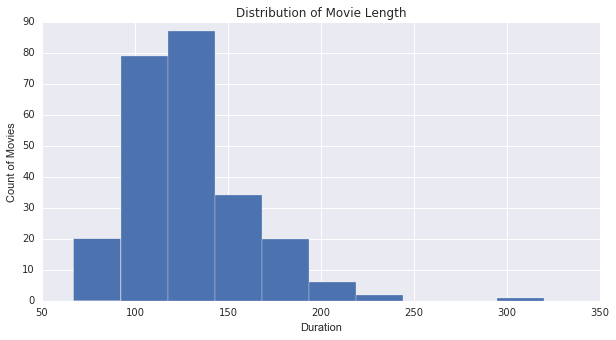

In [1196]:
#normalish distribution for length

raw_df["duration"].plot(kind = "hist", figsize = (10,5))
ax = plt.gca()
ax.set_title("Distribution of Movie Length")
ax.set_ylabel("Count of Movies")
ax.set_xlabel("Duration")
plt.show()

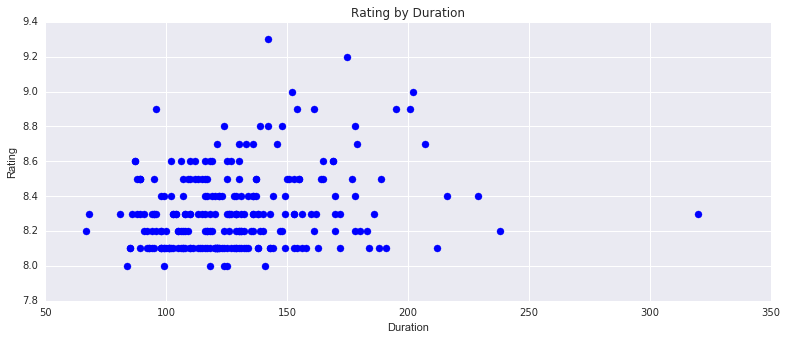

In [1197]:
#rating does't correlate too much with the lenght of the movie

fig = plt.figure(figsize=(13,5))
plt.scatter(raw_df["duration"], raw_df["rating"], s= 50, color = "blue")
plt.title("Rating by Duration")
plt.xlabel("Duration")
plt.ylabel("Rating")
plt.show()

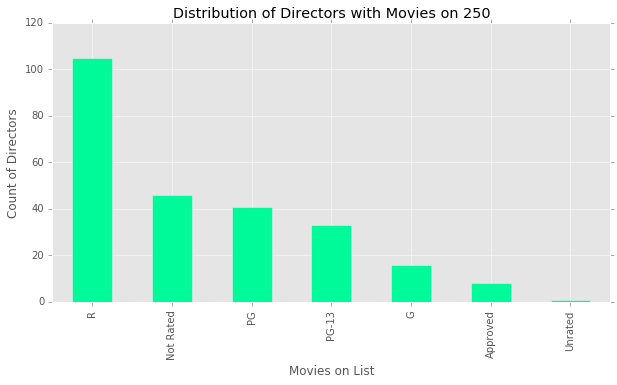

In [810]:
#R is very over represented on the top 250

raw_df["cert"].value_counts().plot(kind = "bar", figsize = (10,5), color = "mediumspringgreen")

ax = plt.gca()
ax.set_title("Distribution of Directors with Movies on 250")
ax.set_ylabel("Count of Directors")
ax.set_xlabel("Movies on List")
plt.show()
#bulk of movies are set to R

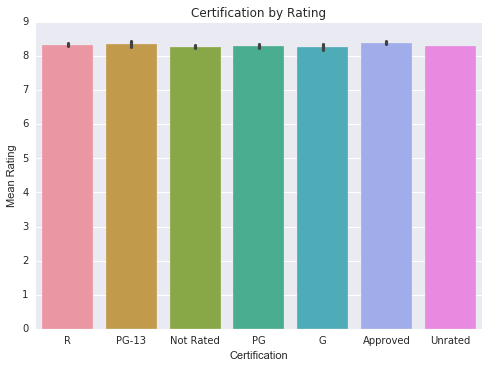

In [819]:
ax = sns.barplot(x = raw_df["cert"], y = raw_df["rating"])
ax.axes.set_title("Certification by Rating")
ax.set_ylabel("Mean Rating")
ax.set_xlabel("Certification")
plt.show()

#Doesn't seem like the means are all that different from each of the ratings

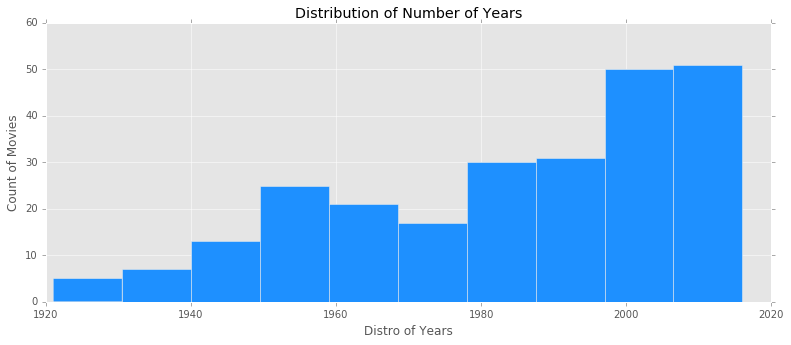

In [796]:
#more recent movies are over represented (not surprising)

fig = plt.figure(figsize=(13,5))
plt.title("Distribution of Number of Years")
plt.xlabel("Distro of Years")
plt.ylabel("Count of Movies")

plt.hist(raw_df["year"], color = "dodgerblue")
plt.show()

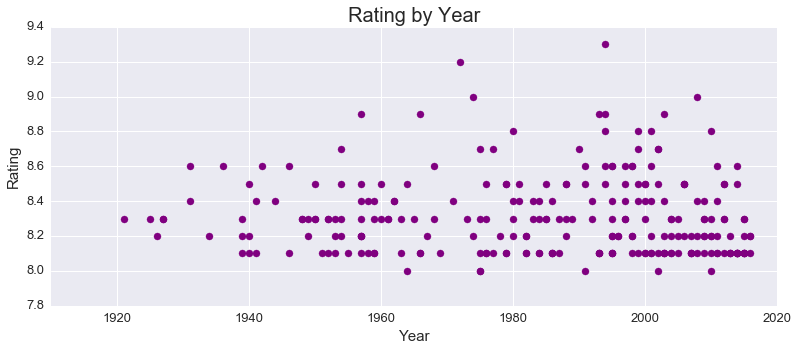

In [23]:
fig = plt.figure(figsize=(13,5))
plt.scatter(raw_df["year"], raw_df["rating"], s= 50, color = "purple")
plt.title("Rating by Year", size = 20)
plt.xlabel("Year", size =15)
plt.ylabel("Rating", size = 15)
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.xlim(1910, 2020)
plt.show()

#only vaguely shows a correlation 

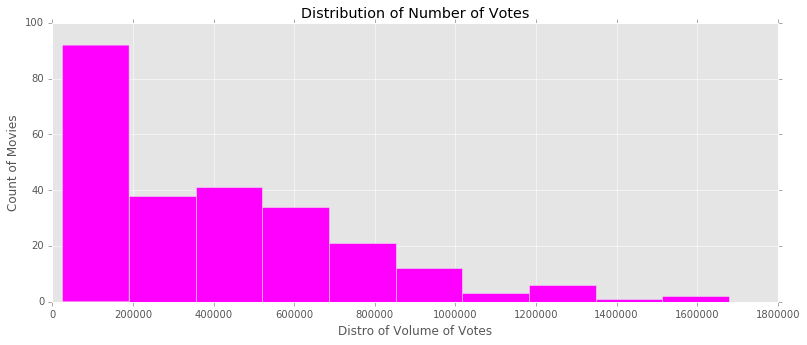

In [787]:
#seems to be the right half of a normal distribution

fig = plt.figure(figsize=(13,5))
plt.title("Distribution of Number of Votes")
plt.xlabel("Distro of Volume of Votes")
plt.ylabel("Count of Movies")

plt.hist(raw_df["num_votes"], color = "magenta")
plt.show()

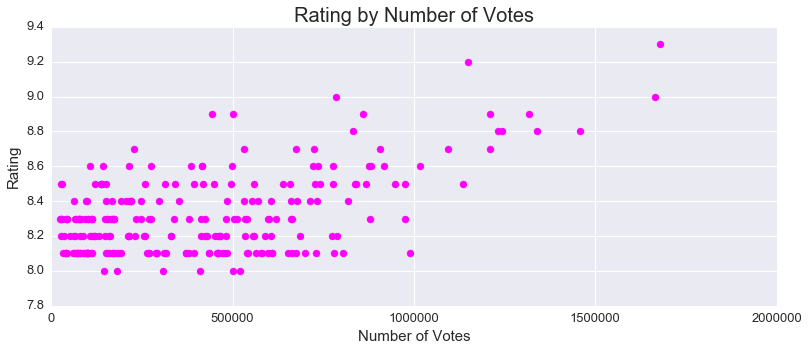

In [22]:
fig = plt.figure(figsize=(13,5))
plt.scatter(raw_df["num_votes"], raw_df["rating"], s= 50, color = "magenta")
plt.title("Rating by Number of Votes", size = 20)
plt.xlabel("Number of Votes", size = 15)
plt.ylabel("Rating", size = 15)
plt.xlim(0, 2000000)
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.show()
#Number of votes definitely shows a slight correlation to rating. Highest rated movie has the highest votes - might be hard to convert a rating once you have a high amount of votes

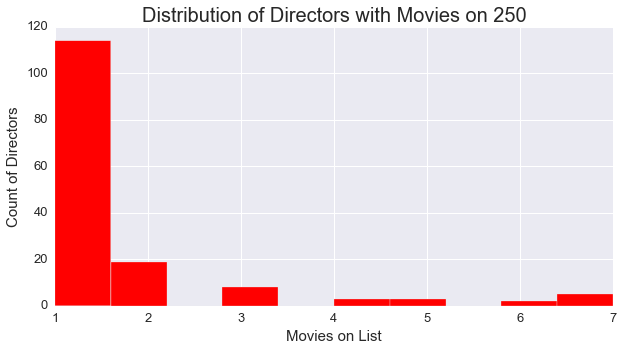

In [20]:
raw_df["director"].value_counts().plot(kind = "hist", figsize = (10,5), color = "red")

ax = plt.gca()
ax.set_title("Distribution of Directors with Movies on 250", size = 20)
ax.set_ylabel("Count of Directors", size = 15)
ax.set_xlabel("Movies on List", size = 15)
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.show()

#nearly half of the directors only have 1 movie on the list although there are a few exceptions

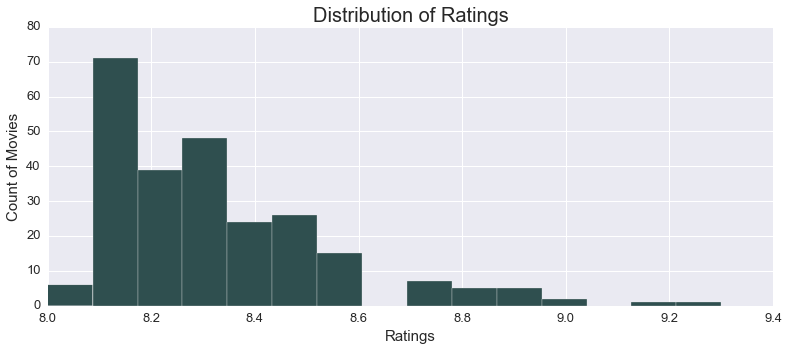

Median is  8.3
Mean is  8.3152


In [12]:
import numpy as np

fig = plt.figure(figsize=(13,5))
plt.hist(raw_df["rating"], bins = 15, color = "darkslategrey")
plt.title("Distribution of Ratings", size = 20)
plt.xlabel("Ratings", size = 15)
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.ylabel("Count of Movies", size = 15)
plt.show()
plt.show

print "Median is ", np.median(raw_df["rating"])
print "Mean is ", np.mean(raw_df["rating"])

#Heavy right skew. Minimum is also 8.

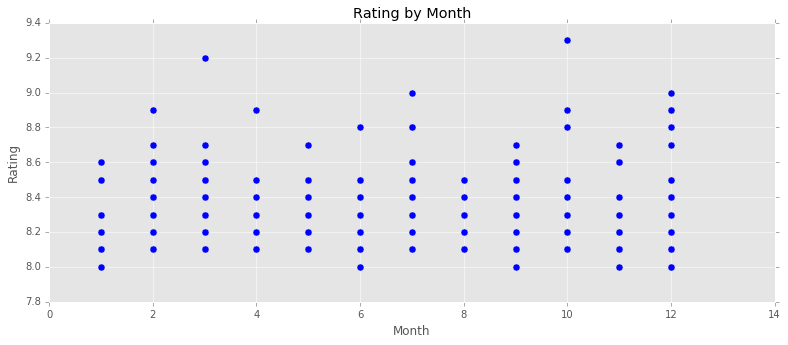

In [518]:
fig = plt.figure(figsize=(13,5))
plt.scatter(raw_df["month"], raw_df["rating"], s= 50)
plt.title("Rating by Month")
plt.xlabel("Month")
plt.ylabel("Rating")
plt.show()

#Doesn't seem like there's a super super clear correlation here between the month and the rating

Convert all the columns with multiple items in it to dummies for features and also to graph. This includes:
- Stars
- Keywords
- Genre
- Keywords

In [77]:
cv = CountVectorizer()
data = cv.fit_transform(raw_df['genre']).todense()
columns = ['genre_'+c for c in cv.get_feature_names()]
genre_df = pd.DataFrame(data, columns=columns)
genre_df.head()

ValueError: empty vocabulary; perhaps the documents only contain stop words

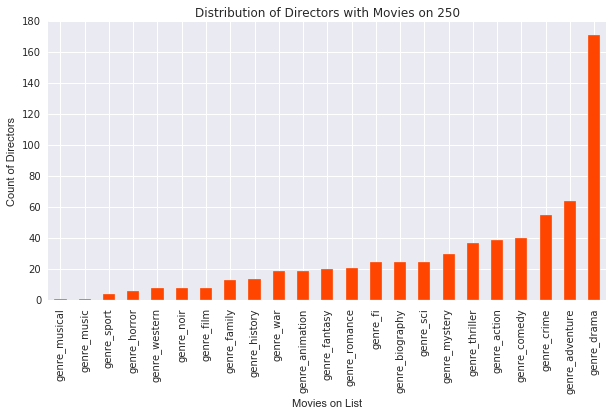

In [841]:
genre_df.sum(0).sort_values().plot(kind = "bar", figsize = (10,5), color = "orangered")

ax = plt.gca()
ax.set_title("Volume of Genres")
ax.set_ylabel("Count of Genres")
ax.set_xlabel("Genre")
plt.show()

#Drama by far has the most

In [15]:
#use keywords as phrases

cv = CountVectorizer(token_pattern=u'(?u)\\w+\.?\\w?\.? \\w+')
data = cv.fit_transform(raw_df['keywords']).todense()
columns = ['keyword_'+c for c in cv.get_feature_names()]
keyword_df = pd.DataFrame(data, columns=columns)
keyword_df.head()

,keyword_14th century,keyword_16th century,keyword_18th century,keyword_7th century,keyword_a door,keyword_a nurse,keyword_a police,keyword_a time,keyword_able to,keyword_action hero,...,keyword_women boxing,keyword_world war,keyword_writers block,keyword_writing a,keyword_written and,keyword_written by,keyword_wrongful imprisonment,keyword_year 1943,keyword_year 1954,keyword_yuma prison
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
keywords = keyword_df.columns.tolist

In [8]:
keywords

<bound method Index.tolist of Index([u'keyword_14th century', u'keyword_16th century',
       u'keyword_18th century', u'keyword_7th century', u'keyword_a door',
       u'keyword_a nurse', u'keyword_a police', u'keyword_a time',
       u'keyword_able to', u'keyword_action hero',
       ...
       u'keyword_women boxing', u'keyword_world war', u'keyword_writers block',
       u'keyword_writing a', u'keyword_written and', u'keyword_written by',
       u'keyword_wrongful imprisonment', u'keyword_year 1943',
       u'keyword_year 1954', u'keyword_yuma prison'],
      dtype='object', length=431)>

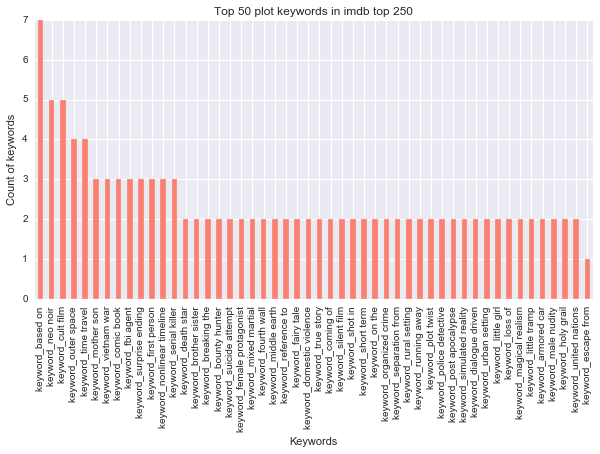

In [9]:
keyword_df.sum(0).sort_values(ascending = False)[0:50].plot(kind = "bar", figsize = (10,5), color = "salmon")

ax = plt.gca()
ax.set_title("Top 50 plot keywords in imdb top 250")
ax.set_ylabel("Count of keywords")
ax.set_xlabel("Keywords")
plt.show()

#top 3 key words are "based on", "neo noir" and "cult film"

In [16]:
cv = CountVectorizer(token_pattern=u'(?u)\\w+\.?\\w?\.? \\w+')
data = cv.fit_transform(raw_df["director"]).todense()
columns = ['director_'+c for c in cv.get_feature_names()]
director_df = pd.DataFrame(data, columns=columns)
director_df.head()

,director_adam elliot,director_akira kurosawa,director_alan mak,director_alejandro g,director_alfred hitchcock,director_andrei tarkovskiy,director_andrew stanton,director_anthony russo,director_anurag kashyap,director_asghar farhadi,...,director_vittorio de,director_von donnersmarck,director_wai wong,director_wes anderson,director_william wyler,director_wilson yip,director_wolfgang petersen,director_woody allen,director_wook park,director_yasujiro ozu
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


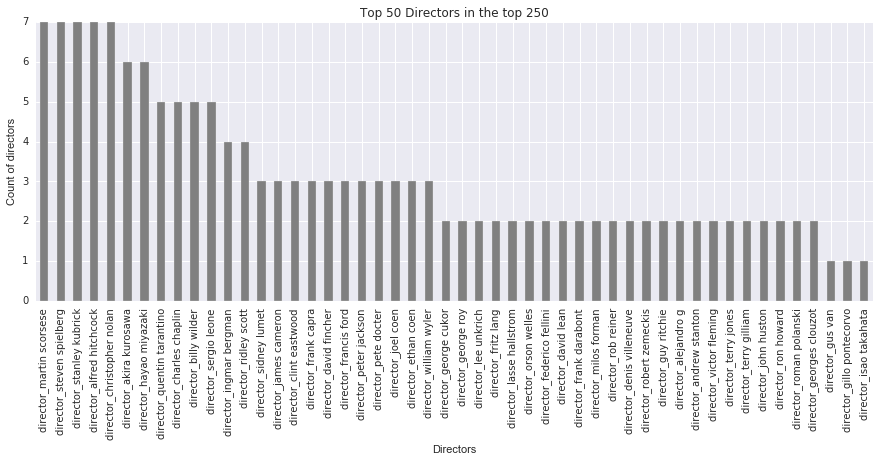

In [875]:
director_df.sum(0).sort_values(ascending = False)[0:50].plot(kind = "bar", figsize = (15,5), color = "gray")

ax = plt.gca()
ax.set_title("Top 50 Directors in the top 250")
ax.set_ylabel("Count of directors")
ax.set_xlabel("Directors")
plt.show()

#5 directors with 7 movies

In [17]:
cv = CountVectorizer(token_pattern=u'(?u)\\w+\.?\\w?\.? \\w+')
data = cv.fit_transform(raw_df["stars"]).todense()
columns = ['star_'+c for c in cv.get_feature_names()]
actor_df = pd.DataFrame(data, columns=columns)
actor_df.head()

,star_anne moss,star_der beek,star_ha kim,star_hiroyuki tagawa,star_ho song,star_jeong kang,star_kyung kim,star_naamir khan,star_naaron eckhart,star_nadolphe menjou,...,star_xedo grandinetti,star_xefd taghmaoui,star_xf3nica villa,star_xf4 mifune,star_xf4 t,star_xf4 yamamura,star_xf4ji matsuda,star_xfb ry,star_xfbko tanaka,star_xfcrgen prochnow
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


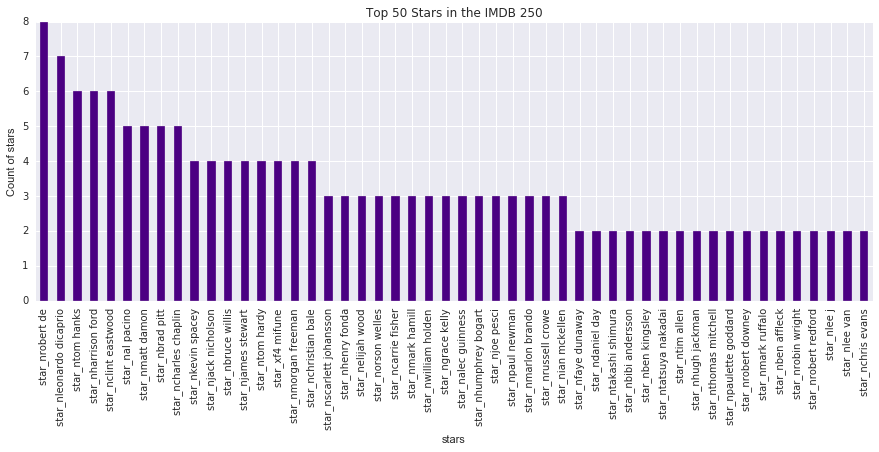

In [876]:
actor_df.sum(0).sort_values(ascending = False)[0:50].plot(kind = "bar", figsize = (15,5), color = "indigo")

ax = plt.gca()
ax.set_title("Top 50 Stars in the IMDB 250")
ax.set_ylabel("Count of stars")
ax.set_xlabel("stars")
plt.show()


### Set up the data for model building

treat y as a classification problem - since the range is from 8.3 to 9.3 and regression is hard to manage on this

In [29]:
#write function to determine 3 ranges

def ratingconverter(rating):
    if rating < 8.5:
        return "8.0 - 8.4"
    elif rating < 8.9:
        return "8.5 - 9.0"
    elif rating < 10:
        return "8.9 - 10.0"

raw_df["new_rating"] = raw_df["rating"].apply(ratingconverter)

In [31]:
y = raw_df["new_rating"]

In [11]:
format_df = raw_df

In [12]:
format_df.head()

,num_votes,rating,title,year,cert,duration,stars,genre,month,keywords,director
0,1679506,9.3,The Shawshank Redemption,1994,R,142.0,"u\nTim Robbins, u\nMorgan Freeman, u\nBob Gunton","Crime, Drama",10,"prison, escape from prison, wrongful imprisonm...",Frank Darabont
1,1149127,9.2,The Godfather,1972,R,175.0,"u\nMarlon Brando, u\nAl Pacino, u\nJames Caan","Crime, Drama",3,"mafia, crime family, patriarch, rise to power,...",Francis Ford Coppola
2,785866,9.0,The Godfather: Part II,1974,R,202.0,"u\nAl Pacino, u\nRobert De Niro, u\nRobert Duv...","Crime, Drama",12,"corrupt politician, revenge, 1950s, lake tahoe...",Francis Ford Coppola
3,1664606,9.0,The Dark Knight,2008,PG-13,152.0,"u\nChristian Bale, u\nHeath Ledger, u\nAaron E...","Action, Adventure, Crime",7,"dc comics, star died before release, based on ...",Christopher Nolan
4,859607,8.9,Schindler's List,1993,R,195.0,"u\nLiam Neeson, u\nRalph Fiennes, u\nBen Kings...","Biography, Drama, History",2,"jew, nazi, german soldier, jewish, german",Steven Spielberg


In [18]:
#convert to dummies

format_df = pd.concat([format_df, pd.get_dummies(format_df["cert"])], axis = 1)

In [19]:
del format_df["rating"]
del format_df["cert"]

In [20]:
format_df = pd.concat([format_df, actor_df], axis = 1)
format_df = pd.concat([format_df, genre_df], axis = 1)
format_df = pd.concat([format_df, keyword_df], axis = 1)
format_df = pd.concat([format_df, director_df], axis = 1)

In [21]:
print len(actor_df.columns)
print len(keyword_df.columns)
print len(director_df.columns)

584
431
167


In [22]:
format_df.head()

del format_df["title"]
del format_df["stars"]
del format_df["keywords"]
del format_df["director"]
del format_df["genre"]

In [24]:
X = format_df

In [25]:
len(X.columns)

#there are a shit ton of columns

1216

In [26]:
X.head()

,num_votes,year,duration,month,Approved,G,Not Rated,PG,PG-13,R,...,director_vittorio de,director_von donnersmarck,director_wai wong,director_wes anderson,director_william wyler,director_wilson yip,director_wolfgang petersen,director_woody allen,director_wook park,director_yasujiro ozu
0,1679506,1994,142.0,10,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,1149127,1972,175.0,3,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,785866,1974,202.0,12,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,1664606,2008,152.0,7,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,859607,1993,195.0,2,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
#found one null value and am replacing

pd.isnull(X["duration"])

0      False
1      False
2      False
3      False
4      False
5      False
6      False
7      False
8      False
9      False
10     False
11     False
12     False
13     False
14     False
15     False
16     False
17     False
18     False
19     False
20     False
21     False
22     False
23     False
24     False
25     False
26     False
27     False
28     False
29     False
       ...  
220    False
221    False
222    False
223    False
224    False
225    False
226    False
227    False
228    False
229    False
230    False
231    False
232    False
233    False
234    False
235    False
236    False
237     True
238    False
239    False
240    False
241    False
242    False
243    False
244    False
245    False
246    False
247    False
248    False
249    False
Name: duration, dtype: bool

In [66]:
X["duration"][237] = 146

/Users/katty/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [67]:
X[X["duration"] == 146]

,num_votes,year,duration,month,Approved,G,Not Rated,PG,PG-13,R,...,director_vittorio de,director_von donnersmarck,director_wai wong,director_wes anderson,director_william wyler,director_wilson yip,director_wolfgang petersen,director_woody allen,director_wook park,director_yasujiro ozu
16,724098,1990,146.0,9,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
237,316954,2011,146.0,8,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
pd.isnull(X).any(1).nonzero()[0]

array([], dtype=int64)

## Fit Data to Trees Models

In [69]:
#train test split 

X_scaled = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = .33)

In [70]:
#fit to GB classifier - very good!

gb = GradientBoostingClassifier()
gb_model = gb.fit(X_train, y_train)
gb_predict = gb_model.predict(X_test)
print "accuracy: ", accuracy_score(y_test, gb_predict)

accuracy:  0.795180722892


In [71]:
#try gridsearch

gb_params = {'n_estimators': [50, 100, 200, 300, 500],
                  'max_depth': [1,3,5,15,25,75,100,200],
                  'max_features': [.25, .50, .75, 1.0]}


gbgrid = GridSearchCV(gb, gb_params)
gbgrid.fit(X_train, y_train)
gbgrid.best_params_

{'max_depth': 3, 'max_features': 1.0, 'n_estimators': 50}

In [72]:
gbgrid_model = gbgrid.fit(X_train, y_train)
gbgrid_predict = gbgrid_model.predict(X_test)
print "accuracy score: ", accuracy_score(y_test, gbgrid_predict)

#performs pretty much the same

accuracy score:  0.795180722892


### Fully assess model

In [73]:
#feature importance

importances = gb_model.feature_importances_

In [74]:
indices = np.argsort(importances)[::-1]

In [75]:
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 0 (0.208582)
2. feature 2 (0.040529)
3. feature 613 (0.037686)
4. feature 604 (0.036502)
5. feature 836 (0.026380)
6. feature 708 (0.025131)
7. feature 534 (0.024746)
8. feature 1 (0.019067)
9. feature 1038 (0.015860)
10. feature 318 (0.015341)
11. feature 560 (0.015144)
12. feature 373 (0.014897)
13. feature 343 (0.014865)
14. feature 792 (0.014455)
15. feature 831 (0.013447)
16. feature 619 (0.013410)
17. feature 512 (0.012832)
18. feature 98 (0.012107)
19. feature 3 (0.011163)
20. feature 548 (0.010671)
21. feature 407 (0.010581)
22. feature 55 (0.009973)
23. feature 786 (0.009890)
24. feature 62 (0.009860)
25. feature 216 (0.009498)
26. feature 566 (0.009021)
27. feature 506 (0.008748)
28. feature 453 (0.008402)
29. feature 379 (0.007982)
30. feature 680 (0.007802)
31. feature 790 (0.007777)
32. feature 745 (0.007771)
33. feature 22 (0.007738)
34. feature 607 (0.007369)
35. feature 1175 (0.007256)
36. feature 33 (0.007088)
37. feature 139 (0.007009)
38. 

In [76]:
#top 8 features:

print X.columns[0]
print X.columns[2]
print X.columns[613]
print X.columns[604]
print X.columns[836]
print X.columns[708]
print X.columns[534]
print X.columns[1]


num_votes
duration
genre_sci
genre_fi
keyword_lake tahoe
keyword_corrupt politician
star_ntom skerritt
year


In [80]:
#print confusion matrix

lr_cm = confusion_matrix(y_test, gb_predict, labels=gb_model.classes_)
lr_cm = pd.DataFrame(lr_cm, columns=gb_model.classes_, index=gb_model.classes_)
lr_cm

#very good at predicting the lower range, not so good at the top ranges

,8.0 - 8.4,8.5 - 9.0,8.9 - 10.0
8.0 - 8.4,61,1,0
8.5 - 9.0,10,7,1
8.9 - 10.0,2,1,0


In [84]:
gb_model.classes_.tolist()

['8.0 - 8.4', '8.5 - 9.0', '8.9 - 10.0']

In [78]:
#print the fancy confusion matrix

import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, title='Confusion matrix', labels=['Positive','Negative'], cmap=plt.cm.Blues):
    
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
        
    plt.title(title)
    plt.ylabel('True Label', size = 12)
    plt.xlabel('Predicted Label', size = 12)
    plt.tight_layout()
    
    width, height = cm.shape
    
    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white',
                        fontsize=18).set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                                                       path_effects.Normal()])

KeyError: 0

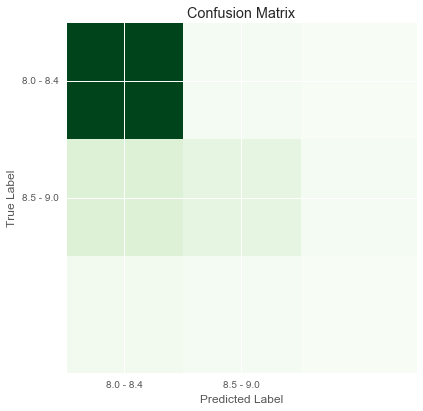

In [85]:
plot_confusion_matrix(lr_cm, title='Confusion Matrix', labels=['8.0 - 8.4', '8.5 - 9.0', '8.9 - 10.0'], cmap=plt.cm.Greens)